## Technical level - 10 classes
Model: google-bert/bert-base-multilingual-uncased
max_seq_length": 128
"train_batch_size": 8,
"eval_batch_size": 8,
"num_train_epochs": 1


In [1]:
import pandas as pd
import torch
import os
import logging
import pickle
import glob
import codecs
import numpy as np
import csv
import math
import numpy
from collections import defaultdict, Counter
from multiprocessing import Pool, cpu_count
from tqdm import tqdm, tqdm_notebook, trange
import matplotlib.pyplot as plt

In [29]:
import torch
from torch.utils.data import (DataLoader, RandomSampler, SequentialSampler, TensorDataset, WeightedRandomSampler)
from torch.utils.data.distributed import DistributedSampler
from tensorboardX import SummaryWriter
from transformers import (BertConfig, AutoTokenizer, BertTokenizer, BertForMaskedLM, AutoModelForMaskedLM, BertForSequenceClassification, WEIGHTS_NAME, AdamW, get_linear_schedule_with_warmup)
from sklearn.metrics import classification_report

## Config

In [3]:
#PATH TO DATA 
train_articles = "datasets/train"
dev_articles = "datasets/dev"
train_TC_labels = "datasets/train_TC_labels"
dev_TC_template = "datasets/TC_labels_for_eval.txt"  
true_file = "datasets/TC.labels_true.txt"

In [16]:
techniques = "propaganda-techniques-names.txt"
PROP_TECH_TO_LABEL = {}  #to dictionary
LABEL_TO_PROP_TECH = {}     #to list
label = 0
with open(techniques, "r") as f:
  for technique in f:
    PROP_TECH_TO_LABEL[technique.replace("\n", "")] = int(label)
    LABEL_TO_PROP_TECH[int(label)] = technique.replace("\n", "")
    label += 1

In [5]:
device = torch.device("cuda")
n_gpu = torch.cuda.device_count()
logging.basicConfig(level=logging.INFO)
logger = logging.getLogger("LOG")

In [6]:
MODEL_CLASSES = {"bert": (BertConfig, BertForSequenceClassification, BertTokenizer)}  #BertForMaskedLM
args = {"data_dir": "datasets/",  
        "model_type": "bert", 
        "model_name": "google-bert/bert-base-multilingual-uncased",
        "output_dir": "output_model_TC_10",  
        "max_seq_length": 128,  ###????
        "train_batch_size": 8,
        "eval_batch_size": 8,
        "num_train_epochs": 1, ####????
        "weight_decay": 0,
        "learning_rate": 4e-5,
        "adam_epsilon": 1e-8,
        "warmup_ratio": 0.06,
        "warmup_steps": 0,
        "max_grad_norm": 1.0,
        "gradient_accumulation_steps": 1,
        "logging_steps": 50,
        "save_steps": 2000,
        "overwrite_output_dir": False}

## Preprocess

In [8]:
def article_to_sequences(article_id, article, tokenizer):
  """
  Divides article into sequences, dividing first by sentences then to powersets
  of the sentences
  """
  # Split the lines by sentences
  curr = 0
  lines = article.split("\n")
  sequences = []
  seq_starts = []
  seq_ends = []

  # For each lines, do:
  for line in lines:
    # If an empty line, just continue
    if line == "":
      curr += 1
      continue

    # Tokenize the line
    tokenized = tokenizer.tokenize(line)

    # For each token, do:
    seq_start = 0
    for ind, token in enumerate(tokenized):
      # Get the token without ## sign
      mod_start_token = token.replace("##", "")

      # Find the start of the sequence in line
      seq_start = line.lower().find(mod_start_token, seq_start)

      # Update the end of the sequence
      seq_end = seq_start

      # For each following tokens in the line, do
      for iter in range(1, len(tokenized) + 1 - ind):
        # Also modify this token
        mod_end_token = tokenized[ind + iter - 1].replace("##", "")
        # Find the end of the token
        seq_end = line.lower().find(mod_end_token, seq_end) + len(mod_end_token)

        sequences.append(tokenizer.convert_tokens_to_string(tokenized[ind: ind + iter]))
        seq_starts.append(curr + seq_start)
        seq_ends.append(curr + seq_end)

      # Update the start of the sequence
      seq_start += len(mod_start_token)

    # Update the current whereabouts
    curr += len(line) + 1

  dataframe = pd.DataFrame(None, range(len(sequences)), ["id", "seq_starts", "seq_ends", "label", "text"])
  dataframe["id"] = [article_id] * len(sequences)
  dataframe["seq_starts"] = seq_starts
  dataframe["seq_ends"] = seq_ends
  dataframe["label"] = [0] * len(sequences)
  dataframe["text"] = sequences
  return dataframe

In [9]:
def article_labels_to_sequences(article, indices_list):
  """
  Divides article into sequences, where each are tagged to be propaganda or not
  """
  # Start at 0 indices, and split the article into lines
  curr = 0
  lines = article.split("\n")
  sequences = {}

  # For each lines, do:
  for line in lines:
    # If an empty line, just continue after adding \n character
    if line == "":
      curr += 1
      continue

    # If nothing in indices_list or current line is not part of propaganda, 
    # just mark it to be none 
    elif indices_list == [] or curr + len(line) <= indices_list[0][0]:
      sequences[line] = 0

    # If current line is part of propaganda, do:
    else:
      # If the propaganda is contained within the line, add it accordingly
      # and pop that indices range
      # If the propaganda span fits entirely within the current line, the line is divided into three parts: before the propaganda, the propaganda span itself, and after the propaganda. Each part is marked with the corresponding label (0 for non-propaganda and 1 for propaganda) in the sequences dictionary.
      if curr + len(line) >= indices_list[0][1]:
        sequences[line[:indices_list[0][0] - curr]] = 0
        sequences[line[indices_list[0][0] - curr:indices_list[0][1] - curr]] = 1
        sequences[line[indices_list[0][1] - curr:]] = 0
        indices_list.pop(0)
      # If the propaganda goes over to the next line, add accordingly and 
      # modify that indices range
      #If the propaganda span extends to the next line, the line is divided into two parts: before the propaganda and after the propaganda. The start index of the next propaganda span is adjusted accordingly.
      else:
        sequences[line[:indices_list[0][0] - curr]] = 0
        sequences[line[indices_list[0][0] - curr:]] = 1
        #indices_list[0][0] = curr + len(line) + 2
        indices_list[0] = (curr + len(line) + 2, indices_list[0][1])  #!!!!
        indices_list[0] = tuple(indices_list[0])                        #!!!

    # Add the current line length plus \n character
    curr += len(line) + 1

  dataframe = pd.DataFrame(None, range(len(sequences)), ["label", "text"])
  dataframe["label"] = sequences.values()
  dataframe["label"] = dataframe["label"].astype(int)
  dataframe["text"] = sequences.keys()
  return dataframe

In [10]:
def convert_dataframe_to_features(dataframe, max_seq_length, tokenizer):
  """
  Converts dataframe into features dataframe, where each feature will
  take form of [CLS] + A + [SEP]
  """
  # Create features
  features = pd.DataFrame(None, range(dataframe.shape[0]), 
                              ["input_ids", "input_mask", "segment_ids", "label_ids"])

  # For each sequence, do:
  for i in range(len(dataframe)):
    # Set first and second part of the sequences
    tokens = tokenizer.tokenize(dataframe["text"][i])

    # If length of the sequence is greater than max sequence length, truncate it
    if len(tokens) > max_seq_length - 2:
        tokens = tokens[:(max_seq_length - 2)]

    # Concatenate the tokens
    tokens = [tokenizer.cls_token] + tokens + [tokenizer.sep_token]

    # Compute the ids
    segment_ids = [0] * len(tokens)
    input_ids = tokenizer.convert_tokens_to_ids(tokens)
    input_mask = [1] * len(input_ids)

    # Zero-pad up to the sequence length.
    padding_length = max_seq_length - len(input_ids)
    pad_token = tokenizer.convert_tokens_to_ids([tokenizer.pad_token])[0]
    input_ids = input_ids + [pad_token] * padding_length
    input_mask = input_mask + [0] * padding_length
    segment_ids = segment_ids + [0] * padding_length
    label_id = dataframe["label"][i]

    # Assert to make sure we have same length
    assert len(input_ids) == max_seq_length
    assert len(input_mask) == max_seq_length
    assert len(segment_ids) == max_seq_length

    # Put the data into features dataframe
    features["input_ids"][i] = input_ids
    features["input_mask"][i] = input_mask
    features["segment_ids"][i] = segment_ids
    features["label_ids"][i] = int(label_id)    ###!!!
    

  return features

In [11]:
def articles_to_dataframe(article_folder, label_folder):
  """
  Preprocesses the articles into dataframes with sequences with binary tags
  """
  # First sort the filenames and make sure we have label file for each articles
  article_filenames = sorted(glob.glob(os.path.join(article_folder, "*.txt")))
  label_filenames = sorted(glob.glob(os.path.join(label_folder, "*.labels.tsv")))
  assert len(article_filenames) == len(label_filenames)

  # Initialize sequences
  sequences = []

  # For each article, do:
  for i in range(len(article_filenames)):
    # Get the id name
    article_id = os.path.basename(article_filenames[i]).split(".")[0][7:]

    # Read in the article
    with codecs.open(article_filenames[i], "r", encoding="utf8") as f:
      article = f.read()

    # Read in the label file and store indices for TC task !!!!
    with open(label_filenames[i], "r") as f:
      reader = csv.reader(f, delimiter="\t")
      article_sequences = []
      labels_list = []
      for row in reader:
        article_sequences.append(article[int(row[2]):int(row[3])])
        labels_list.append(PROP_TECH_TO_LABEL[row[1]])

    sequence = pd.DataFrame(None, range(len(article_sequences)), ["label", "text"])
    sequence["label"] = labels_list
    sequence["text"] = article_sequences   

    # Add to the sequences
    sequences.append(sequence)

  # Concatenate all dataframes
  dataframe = pd.concat(sequences, ignore_index=True)

  return dataframe

In [12]:
def generate_training_dataset_from_articles(articles_folders, labels_folders, tokenizer):
  """
  Generates dataset to go into BERT from articles and labels
  """
  # If generating dataset for evaluation, do:
  logger.info("Generating training dataset...")
    
  # For each articles and labels folder set, turn them into dataframes
  dataframe_list = []
  for i in range(len(articles_folders)):
    logger.info("Generating dataframe for folder %s", articles_folders[i])
    dataframe_list.append(articles_to_dataframe(articles_folders[i], labels_folders[i]))

  # Concatenate the dataframes to make a total dataframe
  dataframe = pd.concat(dataframe_list, ignore_index=True)

  print(dataframe)
  print(dataframe.shape)

  # Process into features dataframe
  logger.info("Creating features from dataframe")
  features = convert_dataframe_to_features(dataframe, args['max_seq_length'], tokenizer) #
     
  # Creating TensorDataset from features
  logger.info("Creating TensorDataset from features dataframe")
  all_input_ids = torch.tensor(features["input_ids"], dtype=torch.long)
  all_input_mask = torch.tensor(features["input_mask"], dtype=torch.long)
  all_segment_ids = torch.tensor(features["segment_ids"], dtype=torch.long)
  all_label_ids = torch.tensor(features["label_ids"], dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  
  return dataset

## Train 

In [13]:
# No weights
def train(train_dataset, model, tokenizer):
  """
  Trains the model with training dataset
  """
  # Initialize various necessary objects
  tb_writer = SummaryWriter()
  train_sampler = RandomSampler(train_dataset)
  train_dataloader = DataLoader(train_dataset, sampler=train_sampler, batch_size=args['train_batch_size'])  #2473
    
  # Compute the total time
  t_total = len(train_dataloader) // args['gradient_accumulation_steps'] * args['num_train_epochs']
  
  # Set the grouped parameters for optimizer
  no_decay = ['bias', 'LayerNorm.weight']
  optimizer_grouped_parameters = [
    {'params': [p for n, p in model.named_parameters() if not any(nd in n for nd in no_decay)], 'weight_decay': args['weight_decay']},
    {'params': [p for n, p in model.named_parameters() if any(nd in n for nd in no_decay)], 'weight_decay': 0.0}
    ]
  
  # Compute warmup steps
  warmup_steps = math.ceil(t_total * args['warmup_ratio'])
  args['warmup_steps'] = warmup_steps if args['warmup_steps'] == 0 else args['warmup_steps']
  
  # Initialize optimizer as Adam with constant weight decay and a linear scheduler with warmup
  optimizer = AdamW(optimizer_grouped_parameters, lr=args['learning_rate'], eps=args['adam_epsilon'])
  scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=args['warmup_steps'], num_training_steps=t_total)

      
  logger.info("***** Running training *****")
  logger.info("  Num examples = %d", len(train_dataset))
  logger.info("  Num Epochs = %d", args['num_train_epochs'])
  logger.info("  Total train batch size  = %d", args['train_batch_size'])
  logger.info("  Gradient Accumulation steps = %d", args['gradient_accumulation_steps'])
  logger.info("  Total optimization steps = %d", t_total)

  # Initialize variables for training
  global_step = 0
  tr_loss, logging_loss = 0.0, 0.0
  model.zero_grad()
  train_iterator = trange(int(args['num_train_epochs']), desc="Epoch")
  
  # Start training!
  for _ in train_iterator:
    epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")
    #epoch_iterator = tqdm.notebook.tqdm(train_dataloader, desc="Iteration")
    for step, batch in enumerate(epoch_iterator):
      model.train()
      batch = tuple(t.to(device) for t in batch)
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2], 
                'labels':         batch[3]}
      outputs = model(**inputs)
      loss = outputs[0]

      if args['gradient_accumulation_steps'] > 1:
        loss = loss / args['gradient_accumulation_steps']
          
      loss.backward()
      torch.nn.utils.clip_grad_norm_(model.parameters(), args['max_grad_norm'])

      tr_loss += loss.item()
      if (step + 1) % args['gradient_accumulation_steps'] == 0:
        optimizer.step()
        scheduler.step() 
        model.zero_grad()
        global_step += 1

        if args['logging_steps'] > 0 and global_step % args['logging_steps'] == 0:
          tb_writer.add_scalar('lr', scheduler.get_lr()[0], global_step)
          tb_writer.add_scalar('loss', (tr_loss - logging_loss)/args['logging_steps'], global_step)
          logging_loss = tr_loss

        if args['save_steps'] > 0 and global_step % args['save_steps'] == 0:
          output_dir = os.path.join(args['output_dir'], 'checkpoint-{}'.format(global_step))
          if not os.path.exists(output_dir):
            os.makedirs(output_dir)
          model_to_save = model.module if hasattr(model, 'module') else model
          model_to_save.save_pretrained(output_dir)
          logger.info("Saving model checkpoint to %s", output_dir)

  return global_step, tr_loss / global_step

### TC

In [14]:
config_class, model_class, tokenizer_class = MODEL_CLASSES[args["model_type"]]
config = config_class.from_pretrained(args["model_name"], num_labels=len(PROP_TECH_TO_LABEL))
tokenizer = tokenizer_class.from_pretrained(args["model_name"])
model = model_class(config)
model.to(device)


BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(105879, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0-11): 12 x BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12

In [15]:
#args['output_dir'] = 'output_model_TC' # Make sure to change the output directory to not overwrite SI model!
train_dataset = generate_training_dataset_from_articles([train_articles], [train_TC_labels], tokenizer)

INFO:LOG:Generating training dataset...
INFO:LOG:Generating dataframe for folder datasets/train
INFO:LOG:Creating features from dataframe


      label                                               text
0         7  Чоловік побив її, потім наніс ножові поранення...
1         9                                              ШАЛЕН
2         9                                              крути
3         9                                           жестяков
4         0                                  або їх відсутніст
...     ...                                                ...
3079      9                                              г*ндо
3080      6                Повальна мобілізація теж не допомож
3081      6                 Йде війна за збереження нашої наці
3082      6                 Йде війна за збереження нашої наці
3083      6                Повальна мобілізація теж не допомож

[3084 rows x 2 columns]
(3084, 2)


INFO:LOG:Creating TensorDataset from features dataframe


In [16]:
global_step, tr_loss = train(train_dataset, model, tokenizer)

C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\transformers\optimization.py:521: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(
INFO:LOG:***** Running training *****
INFO:LOG:  Num examples = 3084
INFO:LOG:  Num Epochs = 1
INFO:LOG:  Total train batch size  = 8
INFO:LOG:  Gradient Accumulation steps = 1
INFO:LOG:  Total optimization steps = 386
Epoch:   0%|          | 0/1 [00:00<?, ?it/s]C:\Windows\Temp\ipykernel_14636\599663890.py:44: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  epoch_iterator = tqdm_notebook(train_dataloader, desc="Iteration")


Iteration:   0%|          | 0/386 [00:00<?, ?it/s]

Epoch: 100%|██████████| 1/1 [03:19<00:00, 199.09s/it]


In [17]:
global_step

386

In [18]:
tr_loss

1.6866482284711433

In [19]:
logger.info(" global_step = %s, average loss = %s", global_step, tr_loss)
logger.info("Saving model checkpoint to %s", args['output_dir'])
model_to_save = model.module if hasattr(model, 'module') else model
model_to_save.save_pretrained(args['output_dir'])
tokenizer.save_pretrained(args['output_dir'])
torch.save(args, os.path.join(args['output_dir'], 'training_args.bin'))

INFO:LOG: global_step = 386, average loss = 1.6866482284711433
INFO:LOG:Saving model checkpoint to output_model_TC


## Evaluate

In [20]:
def generate_TC_eval_dataset_from_article(article_folder, indices_file, tokenizer):
  """
  Generates TC dataset to go into BERT from articles and labels
  """
  # If generating dataset for evaluation, do:
  logger.info("Generating evaluation dataset...")

  # First sort the filenames and make sure we have label file for each articles
  article_filenames = sorted(glob.glob(os.path.join(article_folder, "*.txt")))
  articles = {}

  # For each article, read them in:
  for i in range(len(article_filenames)):
    article_id = os.path.basename(article_filenames[i]).split(".")[0][7:]
    with codecs.open(article_filenames[i], "r", encoding="utf8") as f:
      articles[article_id] = f.read()

  # Read in indices file
  with open(indices_file, "r") as f:
    reader = csv.reader(f, delimiter="\t")
    ids_list = []
    seq_starts = []
    seq_ends = []
    article_sequences = []
    for row in reader:
      ids_list.append(row[0])
      seq_starts.append(row[2])
      seq_ends.append(row[3])
      article_sequences.append(articles[row[0]][int(row[2]):int(row[3])])

  dataframe = pd.DataFrame(None, range(len(ids_list)), ["id", "seq_starts", "seq_ends", "label", "text"])
  dataframe["id"] = ids_list
  dataframe["seq_starts"] = seq_starts
  dataframe["seq_ends"] = seq_ends
  dataframe["label"] = [0] * len(ids_list)
  dataframe["text"] = article_sequences

  print(dataframe)
  print(dataframe.shape)

  # Process into features dataframe
  logger.info("Creating features from dataframe")
  features = convert_dataframe_to_features(dataframe, args['max_seq_length'], tokenizer)
      
  # Creating TensorDataset from features
  logger.info("Creating TensorDataset from features dataframe")
  all_input_ids = torch.tensor(features["input_ids"], dtype=torch.long)
  all_input_mask = torch.tensor(features["input_mask"], dtype=torch.long)
  all_segment_ids = torch.tensor(features["segment_ids"], dtype=torch.long)
  all_label_ids = torch.tensor(features["label_ids"], dtype=torch.long)

  dataset = TensorDataset(all_input_ids, all_input_mask, all_segment_ids, all_label_ids)
  return dataset, dataframe

In [21]:
def classify_techniques(eval_dataframe, eval_dataset, model, tokenizer):
  """
  Classifies a single article dataset and returns article id with indices list
  """
  # Load the eval data and initialize sampler
  eval_sampler = SequentialSampler(eval_dataset)
  eval_dataloader = DataLoader(eval_dataset, sampler=eval_sampler, batch_size=args['eval_batch_size'])

  # Start Classification
  logger.info("***** Running classification for article {} *****".format(eval_dataframe["id"][0]))
  logger.info("  Num sequences = %d", len(eval_dataset))
  logger.info("  Batch size = %d", args['eval_batch_size'])
  preds = None

  # For each batch, evaluate
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):
    model.eval()
    batch = tuple(t.to(device) for t in batch)

    with torch.no_grad():
      inputs = {'input_ids':      batch[0],
                'attention_mask': batch[1],
                'token_type_ids': batch[2],
                'labels':         batch[3]}
      outputs = model(**inputs)
      logits = outputs[1]

    # Get predictions
    if preds is None:
      preds = logits.detach().cpu().numpy()
    else:
      preds = numpy.append(preds, logits.detach().cpu().numpy(), axis=0)

  # Get the most probable prediction
  preds = numpy.argmax(preds, axis=1)

  return preds

In [22]:
#articles_folder = dev_articles
article_filenames = sorted(glob.glob(os.path.join(dev_articles, "*.txt")))

#output_dir = "datasets"
output_file = 'datasets/TC.labels_pred.txt'
f = open(output_file, 'w', newline='')
writer = csv.writer(f, delimiter='\t')
eval_dataset, eval_dataframe = generate_TC_eval_dataset_from_article(dev_articles, dev_TC_template, tokenizer)
predictions = classify_techniques(eval_dataframe, eval_dataset, model, tokenizer)
for i in range(len(predictions)):
  writer.writerow([eval_dataframe["id"][i], LABEL_TO_PROP_TECH[predictions[i]], eval_dataframe["seq_starts"][i], eval_dataframe["seq_ends"][i]])
f.close()

INFO:LOG:Generating evaluation dataset...
INFO:LOG:Creating features from dataframe


           id seq_starts seq_ends  label  \
0      209813          0        3      0   
1      209813         19       36      0   
2      209813         49       65      0   
3      209813        235      249      0   
4      210028          0        6      0   
...       ...        ...      ...    ...   
1323  1633033         68       80      0   
1324  1636639        325      376      0   
1325  1636685        879      885      0   
1326  1636685        968     1051      0   
1327  1636685       1183     1219      0   

                                                   text  
0                                                   Ска  
1                                     продовжує ширитис  
2                                      крейзі-пухнастик  
3                                        головний прико  
4                                                Виродк  
...                                                 ...  
1323                                       Проживає в р  
1324  І

INFO:LOG:Creating TensorDataset from features dataframe
INFO:LOG:***** Running classification for article 209813 *****
INFO:LOG:  Num sequences = 1328
INFO:LOG:  Batch size = 8
C:\Windows\Temp\ipykernel_14636\3392312430.py:16: TqdmDeprecationWarning: This function will be removed in tqdm==5.0.0
Please use `tqdm.notebook.tqdm` instead of `tqdm.tqdm_notebook`
  for batch in tqdm_notebook(eval_dataloader, desc="Evaluating"):


Evaluating:   0%|          | 0/166 [00:00<?, ?it/s]

In [3]:
# Read contents of template.labels_pred.txt
pred_file = "datasets/TC.labels_pred.txt"
true_file = "datasets/TC.labels_true.txt"

# Initialize dictionaries to store IDs and techniques
pred_dict = {}
true_dict = {}

# Read contents of TC.labels_pred.txt
with open(pred_file, "r") as pred_f:
    pred_reader = csv.reader(pred_f, delimiter="\t")
    for row in pred_reader:
        id_ = row[0]
        technique = row[1]
        if id_ not in pred_dict:
            pred_dict[id_] = [technique]
        else:
            pred_dict[id_].append(technique)

# Read contents of TC.labels_true.txt
with open(true_file, "r") as true_f:
    true_reader = csv.reader(true_f, delimiter="\t")
    for row in true_reader:
        id_ = row[0]
        technique = row[1]
        if id_ not in true_dict:
            true_dict[id_] = [technique]
        else:
            true_dict[id_].append(technique)

In [10]:
# Initialize lists to store true and predicted labels
true_labels = []
predicted_labels = []

# Iterate through the keys of the dictionaries
for key in true_dict.keys():
    # Check if the key exists in both dictionaries
    if key in pred_dict:
        # Append true and predicted labels
        true_labels.extend(true_dict[key])
        predicted_labels.extend(pred_dict[key])

# Generate classification report
report = classification_report(true_labels, predicted_labels)

# Print classification report
print(report)

                      precision    recall  f1-score   support

         Black_White       0.00      0.00      0.00        43
         Doubts_Army       0.00      0.00      0.00        45
   Doubts_government       0.00      0.00      0.00       239
        Doubts_media       0.00      0.00      0.00        16
        Doubts_other       0.00      0.00      0.00         6
     Doubts_partners       0.00      0.00      0.00        19
       Emotion_Anger       0.00      0.00      0.00       192
        Emotion_Fear       0.21      0.65      0.32       212
Emotion_Hate_Disgust       0.00      0.00      0.00       123
       Emotion_other       0.54      0.86      0.66       433

            accuracy                           0.38      1328
           macro avg       0.08      0.15      0.10      1328
        weighted avg       0.21      0.38      0.27      1328


C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
C:\Users\Ната\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\metrics\_classification.py:1469: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, mo

In [14]:
true_labels

['Emotion_Fear',
 'Emotion_Fear',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_Fear',
 'Emotion_Fear',
 'Emotion_Fear',
 'Emotion_other',
 'Emotion_other',
 'Emotion_Anger',
 'Doubts_government',
 'Emotion_Fear',
 'Emotion_other',
 'Emotion_Hate_Disgust',
 'Emotion_Anger',
 'Emotion_other',
 'Emotion_Fear',
 'Emotion_Anger',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_Hate_Disgust',
 'Emotion_other',
 'Emotion_Anger',
 'Emotion_Anger',
 'Doubts_other',
 'Emotion_Anger',
 'Doubts_government',
 'Emotion_other',
 'Emotion_other',
 'Doubts_government',
 'Emotion_other',
 'Doubts_government',
 'Doubts_government',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_Hate_Disgust',
 'Emotion_Anger',
 'Emotion_other',
 'Emotion_other',
 'Emotion_Anger',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Emotion_other',
 'Black_White

In [18]:
PROP_TECH_TO_LABEL

{'Doubts_government': 0,
 'Doubts_Army': 1,
 'Doubts_media': 2,
 'Doubts_partners': 3,
 'Doubts_other': 4,
 'Black_White': 5,
 'Emotion_Fear': 6,
 'Emotion_Anger': 7,
 'Emotion_Hate_Disgust': 8,
 'Emotion_other': 9}

In [24]:
# Compute multilabel confusion matrix
from sklearn.metrics import multilabel_confusion_matrix
class_names = ["Doubts_government", 
               "Doubts_Army",
               "Doubts_media",
               "Doubts_partners",
               "Doubts_other",
               "Black_White",
               "Emotion_Fear",
               "Emotion_Anger",
               "Emotion_Hate_Disgust",
               "Emotion_other"]

mcm = multilabel_confusion_matrix(true_labels, predicted_labels, labels = class_names)

# Print confusion matrix
print("Confusion Matrix:")
for i, confusion_matrix in enumerate(mcm):
    print(f"Class {class_names[i]}:")
    print(confusion_matrix)
    print()

Confusion Matrix:
Class Doubts_government:
[[1089    0]
 [ 239    0]]

Class Doubts_Army:
[[1283    0]
 [  45    0]]

Class Doubts_media:
[[1312    0]
 [  16    0]]

Class Doubts_partners:
[[1309    0]
 [  19    0]]

Class Doubts_other:
[[1322    0]
 [   6    0]]

Class Black_White:
[[1285    0]
 [  43    0]]

Class Emotion_Fear:
[[614 502]
 [ 75 137]]

Class Emotion_Anger:
[[1136    0]
 [ 192    0]]

Class Emotion_Hate_Disgust:
[[1205    0]
 [ 123    0]]

Class Emotion_other:
[[579 316]
 [ 60 373]]


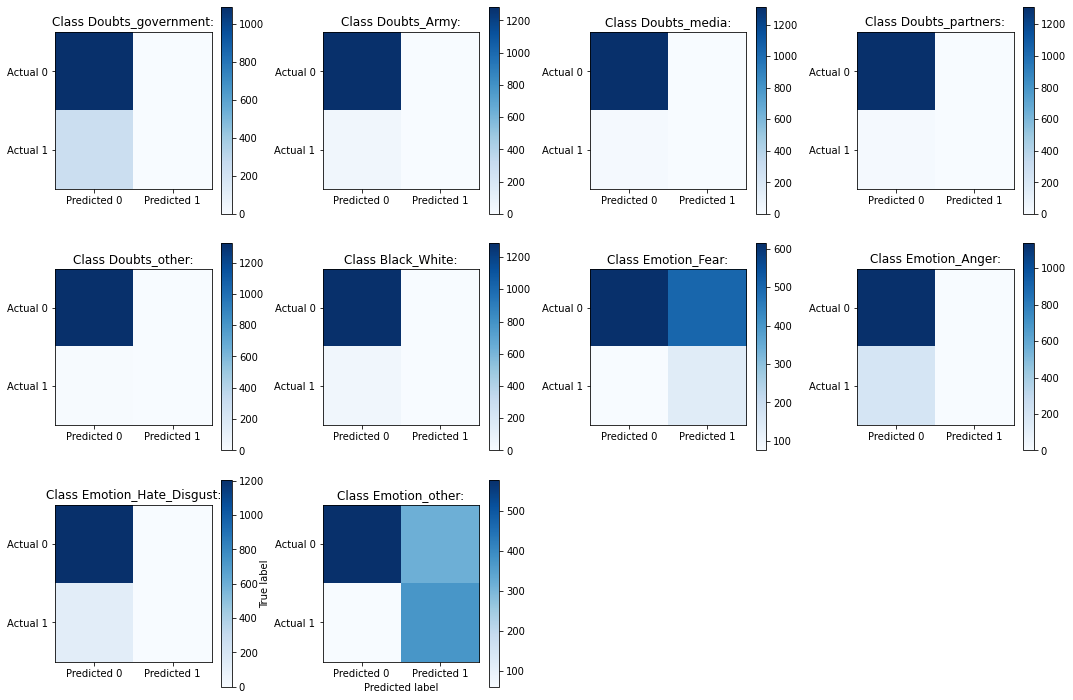

In [26]:
plt.figure(figsize=(15, 10))

# Iterate through the confusion matrices and plot them in a single plot
for i, confusion_matrix in enumerate(mcm):
    tn, fp, fn, tp = confusion_matrix.ravel()
    matrix = np.array([[tn, fp], [fn, tp]])
    plt.subplot(3, 4, i + 1)
    plt.imshow(matrix, interpolation='nearest', cmap=plt.cm.Blues)
    plt.title(f'Class {class_names[i]}:')
    plt.colorbar()
    tick_marks = np.arange(2)
    plt.xticks(tick_marks, ['Predicted 0', 'Predicted 1'])
    plt.yticks(tick_marks, ['Actual 0', 'Actual 1'])

# Adjust layout and labels
plt.tight_layout()
plt.ylabel('True label')
plt.xlabel('Predicted label')
plt.show()


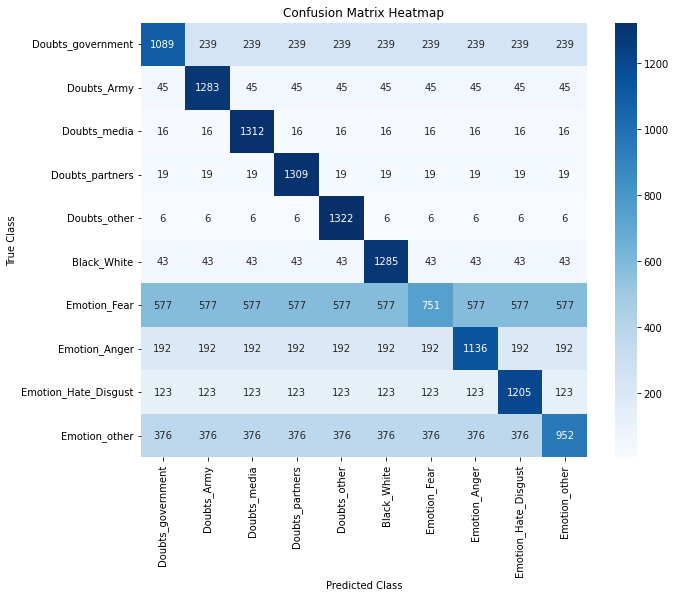

In [28]:
import seaborn as sns

# Compute multilabel confusion matrix with class names
mcm = multilabel_confusion_matrix(true_labels, predicted_labels, labels=class_names)

# Create an empty confusion matrix to accumulate values
confusion_matrix_heatmap = np.zeros((len(class_names), len(class_names)), dtype=int)

# Populate the confusion matrix heatmap with the values from the multilabel confusion matrix
for i, confusion_matrix in enumerate(mcm):
    tn, fp, fn, tp = confusion_matrix.ravel()
    confusion_matrix_heatmap[i, i] = tn + tp  # Diagonal contains true negatives and true positives
    for j in range(len(class_names)):
        if j != i:
            confusion_matrix_heatmap[i, j] = fp + fn  # Off-diagonal contains false positives and false negatives

# Create a heatmap using seaborn
plt.figure(figsize=(10, 8))
sns.heatmap(confusion_matrix_heatmap, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)
plt.xlabel('Predicted Class')
plt.ylabel('True Class')
plt.title('Confusion Matrix Heatmap')
plt.show()
